In [31]:
from pathlib import Path
from pyproj import CRS, Transformer

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# reading input scenario

urbansim_source_dir = "../beam_root/production/sfbay/urbansim"

persons = pd.read_csv(f"{urbansim_source_dir}/persons.csv.gz")
households = pd.read_csv(f"{urbansim_source_dir}/households.csv.gz")
plans = pd.read_csv(f"{urbansim_source_dir}/plans.csv.gz")
blocks = pd.read_csv(f"{urbansim_source_dir}/blocks.csv.gz")

print(f"Number of persons: {persons.shape[0]}, number of households: {households.shape[0]}, number of unique persons in plans: {plans['person_id'].nunique()}")

Number of persons: 721814, number of households: 275783, number of unique persons in plans: 644216


In [9]:
# reading the shp file and converting it to activities `x` and `y` CRS

shape_file_path = "../local_files/vta-filtering-plans/MTC-1454-TAZ.zip"

# reading the shape file
shp_df_wrong_crs = gpd.read_file(shape_file_path)

# converting the shapefile to required CRS
shp_df_full = shp_df_wrong_crs.to_crs(4326)

# using only selected districts
selected_districts = set([8, 9, 10, 11, 12, 13, 14])
shp_df = shp_df_full[shp_df_full['SUPERD'].isin(selected_districts)]

print(f"Selected districts has: {len(shp_df)} rows, full shape file has {len(shp_df_full)} rows.")
display(shp_df.head(2))

Selected districts has: 368 rows, full shape file has 1454 rows.


,OBJECTID,SUPERD,TAZ1454,Shape__Are,Shape__Len,geometry
794,795,11,547,1.924186e+06,6068.548124,"POLYGON ((-121.89867 37.35264, -121.90027 37.3..."
795,796,11,542,1.018191e+06,4120.214275,"POLYGON ((-121.92197 37.34604, -121.91957 37.3..."


In [ ]:
# getting CRS of the shp file

shp_df.crs

In [ ]:
# saving filtered-out shapefile dataframe to files (by folder path)
shp_df.to_file("../local_files/vta-filtering-plans/MTC-1454-TAZ-selected-districts")

In [12]:
# getting activities

activities = plans[plans['ActivityElement'] == 'activity'][['person_id','ActivityType','x','y']]

# sanity check
if 0 == activities.isna().sum().sum():
    print(f'All persons, activities and X Y coordinates are set. Number of activities: {len(activities)}')

display(activities.head(2))

All persons, activities and X Y coordinates are set. Number of activities: 3156026


,person_id,ActivityType,x,y
0,4.0,Home,-122.227937,37.854097
2,4.0,othdiscr,-122.242641,37.793755


In [11]:
# getting geo_activities dataframe with specified CRS

points = gpd.points_from_xy(activities["x"], activities["y"], crs="EPSG:4326")
geo_activities = gpd.GeoDataFrame(activities, geometry=points)
geo_activities.head(2)

,person_id,ActivityType,x,y,geometry
0,4.0,Home,-122.227937,37.854097,POINT (-122.22794 37.85410)
2,4.0,othdiscr,-122.242641,37.793755,POINT (-122.24264 37.79376)


In [ ]:
# saving activities locations to shape file
geo_activities.to_file(filename="../local_files/vta-filtering-plans/activities_shape.zip", driver='ESRI Shapefile')

In [15]:
# getting activities within shape file

# `predicate` must be one of {'covers', 'within', 'contains', 'contains_properly', 'covered_by', 'intersects', 'crosses', 'overlaps', None, 'touches'}
geo_activities_joined = geo_activities.sjoin(shp_df, predicate="within")

# calculating how many persons there are in original activities and with activities within shape file
persons_within_area = set(geo_activities_joined['person_id'].unique())
persons_total = activities['person_id'].nunique()

print(f"Activities within selected shape file: {len(geo_activities_joined)}, total activities: {len(geo_activities)}.")
print(f"Persons within selected shape file: {len(persons_within_area)}, total persons: {persons_total}")

geo_activities_joined.head(2)

Activities within selected shape file: 824299, total activities: 3156026.
Persons within selected shape file: 188268, total persons: 644216


,person_id,ActivityType,x,y,geometry,index_right,OBJECTID,SUPERD,TAZ1454,Shape__Are,Shape__Len
38,115.0,school,-121.856673,37.400814,POINT (-121.85667 37.40081),912,913,12,626,1.437880e+06,5875.356905
174,172.0,school,-121.853470,37.400872,POINT (-121.85347 37.40087),912,913,12,626,1.437880e+06,5875.356905


# approach #1 - downsampling

In [ ]:
# downsampling scenario based on selected persons
# usually we take persons ids, then households, then take all persons within households, but this time I took only selected persons 

selected_persons_df = persons[persons['person_id'].isin(persons_within_area)]
print(f"there are {len(selected_persons_df)} selected persons (out of {len(persons)})")

selected_households_ids = set(selected_persons_df['household_id'].unique())
selected_households_df = households[households['household_id'].isin(selected_households_ids)]
print(f"there are {len(selected_households_df)} selected households (out of {len(households)})")

selected_plans_df = plans[plans['person_id'].isin(persons_ids_within_shape)]
print(f"there are {len(selected_plans_df)} selected plans (out of {len(plans)})")

selected_block_ids = set(selected_households_df['block_id'])
selected_blocks_df = blocks[blocks['block_id'].isin(selected_block_ids)]
print(f"there are {len(selected_blocks_df)} selected blocks (out of {len(blocks)})")

In [ ]:
# sanity check

selected_persons_df['age'].hist(bins=50, figsize=(15,3))

In [ ]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_plans_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

# approach #2 - clearing modes for selected persons

In [34]:
# splitting plans into two dataframes based on selected persons IDs and clearing modes for selected persons plans

plans_within = plans[plans['person_id'].isin(persons_within_area)].copy()
plans_rest = plans[~plans['person_id'].isin(persons_within_area)].copy()

# reset modes
plans_within['trip_mode'] = np.nan

# concat two dataframes back with sorting by person Id and plan element index
plans_cleared = pd.concat([plans_within,plans_rest]).sort_values(['person_id','PlanElementIndex'])

plans_within['person_id'].nunique(), plans_rest['person_id'].nunique(), plans_cleared['person_id'].nunique()

(188268, 455948, 644216)

In [45]:
# check if everything apart modes are equal in old plans and changed plans
columns = ["trip_id","person_id","number_of_participants","PlanElementIndex","ActivityElement","ActivityType","x","y","departure_time"]
plans_cleared[columns].equals(plans[columns])

True

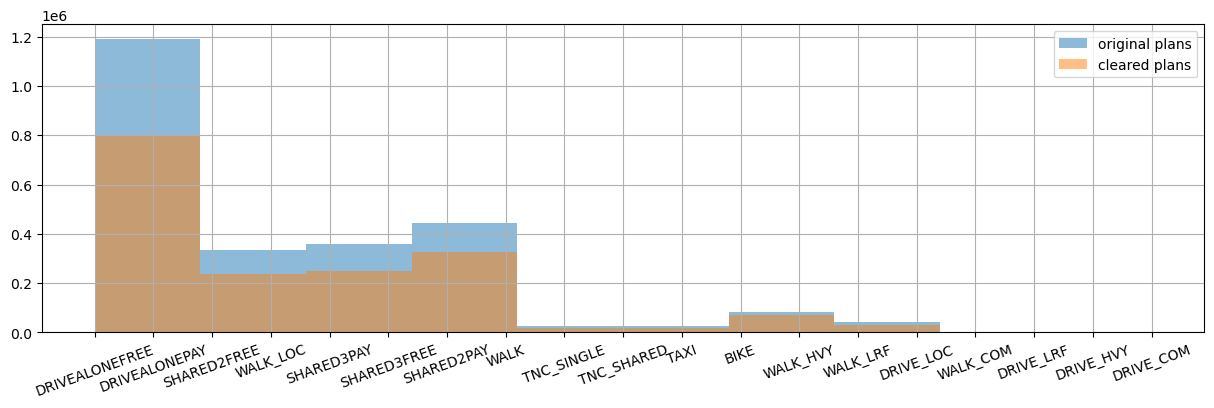

In [35]:
# sanity check

ax = plans['trip_mode'].hist(figsize=(15,4), xrot=20, alpha=0.5, label="original plans")
plans_cleared['trip_mode'].hist(ax=ax, alpha=0.5, label="cleared plans")
ax.legend()

In [49]:
# saving changed plans to output dir

out_dir = 'sampled_scenario'

Path(out_dir).mkdir(parents=True, exist_ok=True)

plans_cleared.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')

# approach #3 remove all plans\people with only specific modes and with all OD outside the study area)

In [50]:
# looking for plans for persons outside of study area 

plans_outside_area = plans[~plans['person_id'].isin(persons_within_area)]
plans_outside_area['person_id'].nunique()

455948

In [54]:
plans_outside_area.head(2)

,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time
0,NaN,4.0,NaN,NaN,1,activity,Home,-122.227937,37.854097,15.285
1,1513.0,4.0,1.0,DRIVEALONEFREE,2,leg,NaN,NaN,NaN,NaN


In [73]:
plans_outside_area['trip_mode'].value_counts()

DRIVEALONEFREE    404616
DRIVEALONEPAY     393738
WALK              175844
SHARED2FREE       154286
SHARED2PAY        151482
SHARED3FREE       123804
SHARED3PAY        123774
WALK_LOC           84140
WALK_HVY           40806
BIKE               31034
WALK_LRF           29412
TNC_SINGLE         17951
TNC_SHARED          9752
TAXI                9115
WALK_COM            1692
DRIVE_LOC            797
DRIVE_HVY            647
DRIVE_LRF            152
DRIVE_COM             10
Name: trip_mode, dtype: int64

In [88]:
# take only trips (with trip mode not NA)
df1 = plans_outside_area[~plans_outside_area['trip_mode'].isna()]

# take only plans that are not contains selected modes:
modes_to_filter_out = set(['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED2PAY','SHARED3FREE','SHARED3PAY','WALK','BIKE'])
df2 = df1[~df1['trip_mode'].isin(modes_to_filter_out)]

# take ID of persons outside area with allowed modes
persons_outside_with_allowed_modes = set(df2['person_id'].unique())

persons_within_and_outside_with_allowed_modes = set()
persons_within_and_outside_with_allowed_modes.update(persons_within_area)
persons_within_and_outside_with_allowed_modes.update(persons_outside_with_allowed_modes)

len(persons_within_and_outside_with_allowed_modes), len(persons_outside_with_allowed_modes)

(284215, 95947)

<AxesSubplot: >

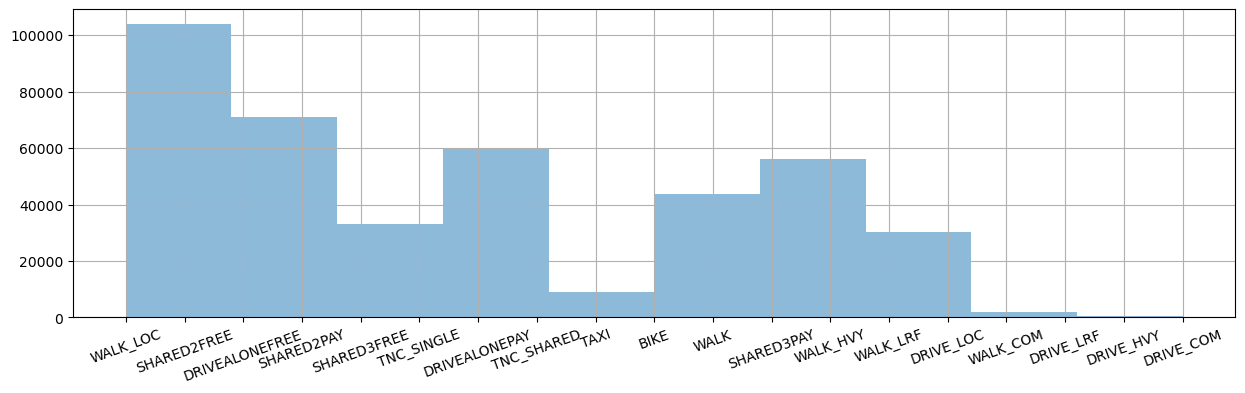

In [90]:
df3 = plans[plans['person_id'].isin(persons_outside_with_allowed_modes)]
df3['trip_mode'].hist(figsize=(15,4), xrot=20, alpha=0.5, label="original plans")

In [91]:
# get plans without persons outside area that has only restricted modes

plans_filtered = plans[plans['person_id'].isin(persons_within_and_outside_with_allowed_modes)]

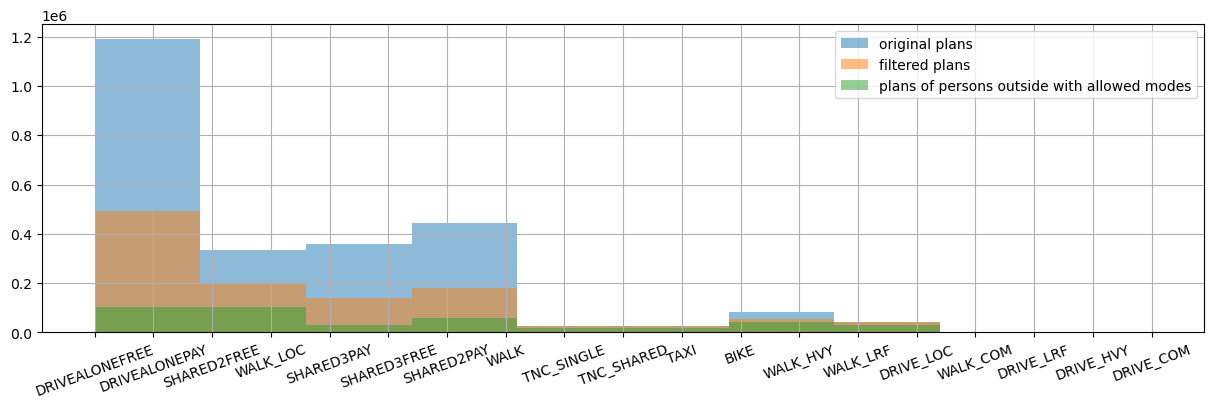

In [92]:
# sanity check

ax = plans['trip_mode'].hist(figsize=(15,4), xrot=20, alpha=0.5, label="original plans")
plans_filtered['trip_mode'].hist(ax=ax, alpha=0.5, label="filtered plans")
plans[plans['person_id'].isin(persons_outside_with_allowed_modes)]['trip_mode'].hist(ax=ax, alpha=0.5, label="plans of persons outside with allowed modes")

ax.legend()

In [94]:
# downsampling scenario based on selected persons
# usually we take persons ids, then households, then take all persons within households, but this time I took only selected persons 

selected_persons_df = persons[persons['person_id'].isin(persons_within_and_outside_with_allowed_modes)]
print(f"there are {len(selected_persons_df)} selected persons (out of {len(persons)})")

selected_households_ids = set(selected_persons_df['household_id'].unique())
selected_households_df = households[households['household_id'].isin(selected_households_ids)]
print(f"there are {len(selected_households_df)} selected households (out of {len(households)})")

selected_plans_df = plans[plans['person_id'].isin(persons_within_and_outside_with_allowed_modes)]
print(f"there are {len(selected_plans_df)} selected plans (out of {len(plans)})")

selected_block_ids = set(selected_households_df['block_id'])
selected_blocks_df = blocks[blocks['block_id'].isin(selected_block_ids)]
print(f"there are {len(selected_blocks_df)} selected blocks (out of {len(blocks)})")

there are 284215 selected persons (out of 721814)
there are 153436 selected households (out of 275783)
there are 2621275 selected plans (out of 5667836)
there are 43540 selected blocks (out of 109228)


In [95]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario__within_area_plus_outside_with_allowed_modes__with_modes'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_plans_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

In [96]:
# splitting plans into two dataframes based on selected persons IDs and clearing modes for selected persons plans

plans_within = selected_plans_df[selected_plans_df['person_id'].isin(persons_within_area)].copy()
plans_rest = selected_plans_df[~selected_plans_df['person_id'].isin(persons_within_area)].copy()

# reset modes
plans_within['trip_mode'] = np.nan

# concat two dataframes back with sorting by person Id and plan element index
selected_plans_area_without_modes_df = pd.concat([plans_within, plans_rest]).sort_values(['person_id','PlanElementIndex'])
selected_plans_area_without_modes_df.shape

(2621275, 10)

In [97]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario__within_area_plus_outside_with_allowed_modes__area_without_modes'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_plans_area_without_modes_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

In [100]:
# removing all modes altogether
selected_plans_without_modes_df = selected_plans_area_without_modes_df.copy()
selected_plans_without_modes_df['trip_mode'] = np.nan

In [101]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario__within_area_plus_outside_with_allowed_modes__without_modes'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_plans_without_modes_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

/tmp/ipykernel_1340/2819548468.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  plans2 = pd.read_csv("sampled_scenario__within_area_plus_outside_with_allowed_modes__area_without_modes/plans.csv.gz")


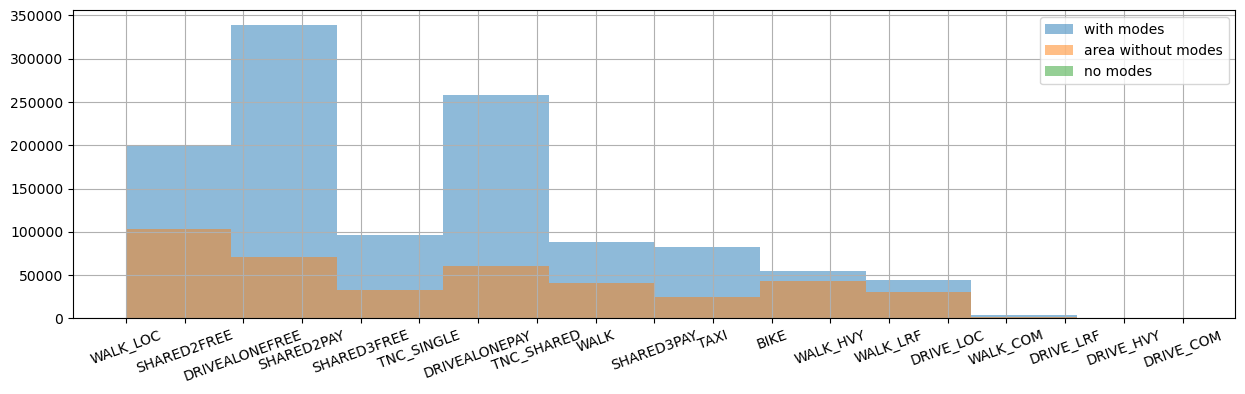

In [102]:
plans1 = pd.read_csv("sampled_scenario__within_area_plus_outside_with_allowed_modes__with_modes/plans.csv.gz")
plans2 = pd.read_csv("sampled_scenario__within_area_plus_outside_with_allowed_modes__area_without_modes/plans.csv.gz")
plans3 = pd.read_csv("sampled_scenario__within_area_plus_outside_with_allowed_modes__without_modes/plans.csv.gz")


ax = plans1['trip_mode'].hist(figsize=(15,4), xrot=20, alpha=0.5, label="with modes")
plans2['trip_mode'].hist(ax=ax, alpha=0.5, label="area without modes")
plans3['trip_mode'].hist(ax=ax, alpha=0.5, label="no modes")

ax.legend()